In [28]:
%load_ext autoreload

%autoreload 2

import numpy as np
import time
from matplotlib import pyplot as plt
import os
import camb
from camb import model

from scipy.interpolate import interp1d

from axionCAMB_and_lin_PS import axionCAMB_wrapper 
from axionCAMB_and_lin_PS import load_cosmology  
from axionCAMB_and_lin_PS import lin_power_spectrum 


from halo_model import HMcode_params
from halo_model import PS_nonlin_cold
from halo_model import PS_nonlin_axion

from axion_functions import axion_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## comparison MDM to LCDM

##################################################
axionHMcode is running
##################################################
Set-up experiment parameters
computing the non-linear total matter power spectrum in the folowing MDM colsmology 

omega_m = 0.14237 
omega_cdm = 0.108 
omega_ax = 0.012 
omega_b = 0.02237 
m_ax = 1e-25eV 
z = 0.0 
h = 0.674 

--------------------------------------------------
axionCAMB is running. Computes transfer function for cosmology with a axion fraction of 0.1
computation time for axionCAMB: 0 s
--------------------------------------------------
Create dictionary with parameters of HMCode2020
Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.
10.952282434120024 5.2


/Users/sophievogt/Documents/PhD_local/projects/axion_projects/axionHMcode/axion_functions/axion_cutoff_mass.py:83: UserWarning: Warning. Redshift z = 0.00 is not in the range [1.0, 8.0] where beta2 is defined. Extrapolate
  if f < f_values.min() or f > f_values.max():


computation time AxionHMcode up to here: 6 s
--------------------------------------------------
Caluclate non-linear power spectrum in mixed DM cosmology with the halo model


/Users/sophievogt/Documents/PhD_local/projects/axion_projects/axionHMcode/halo_model/PS_nonlin_axion.py:153: RuntimeWarning: invalid value encountered in power
  PS_total_cross = axion_dic['frac_cluster']*((one_halo_term_cross**(alpha_param[1]) + two_halo_term_cross**(alpha_param[1]))**(1/alpha_param[1])) + (1-axion_dic['frac_cluster'])*np.sqrt(PS_ax * PS_cold_nonlin)


Caluclate non-linear power spectrum in LCDM cosmology with the halo model
--------------------------------------------------
Save the non-linear power spectra in a file in the folowing order:
k [h/Mpc], non-lin total matter PS with axions [(Mpc/h)^3] and non-lin total matter PS in LCDM [(Mpc/h)^3]
##################################################
axionHMcode is finished, total computation time without axionCAMB: 6 s
##################################################


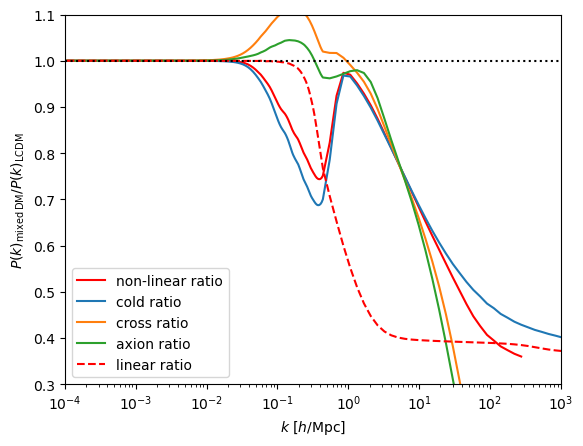

In [32]:
start = time.time()

print('#' * 50)
print('axionHMcode is running')
print('#' * 50)

################################################################################
# Set-up experiment parameters and run axionCAMB
################################################################################
#print('#' * 50)
print('Set-up experiment parameters')
#print('#' * 50)

#IMPORTANT: give the correct path to the intput file which contains all important cosmological parameter
input_file_path = 'input_file.txt'
try:
    f = open(input_file_path)
except IOError:
    print("Input file not accessible, pleas check the file path")
finally:
    f.close()
    
#IMPORTANT:Change here the path to the axionCAMB executable path directory (second path in the function)
# assumes that thee axionCAMB executable is names .camb
axionCAMB_exe_path = '/Users/sophievogt/Documents/axionCAMB'
if os.path.exists(axionCAMB_exe_path+'/./camb') == False:
    print("executabel axionCAMB is not in the given directory, pleas check the path")
      
    
################################################################################    
# save cosmological parameter in a dictionary 
################################################################################
cosmos = load_cosmology.load_cosmology_input(input_file_path) 
cosmos_LCDM = load_cosmology.load_cosmology_input(input_file_path, LCDM = True)
print("computing the non-linear total matter power spectrum in the folowing MDM colsmology \n")
print("omega_m = {0} \nomega_cdm = {1} \nomega_ax = {2} \nomega_b = {3} \nm_ax = {4}eV \nz = {5} \nh = {6} \n".format(cosmos['omega_m_0'], cosmos['omega_d_0'], cosmos['omega_ax_0'], cosmos['omega_b_0'], 
                                                                                                                          cosmos['m_ax'], cosmos['z'], cosmos['h']))



################################################################################
# Run axionCAMB on mixed and LCDM cosmology 
################################################################################
print('-' * 50)
print("axionCAMB is running. Computes transfer function for cosmology with a axion fraction of {}"
      .format(cosmos['Omega_ax_0']/(cosmos['Omega_ax_0']+cosmos['Omega_d_0'])))
# axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB.txt', 
#                                    cosmos, output_root='paramfiles/cosmos', print_info = False)
# axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB.txt', 
#                                 axionCAMB_exe_path, 
#                                 cosmos, print_info = False)

# print("axionCAMB is running. Computes transfer function for a LCDM cosmology")
# axionCAMB_wrapper.axioncamb_params('paramfiles/paramfile_axionCAMB_LCDM.txt', 
#                                    cosmos_LCDM, output_root='paramfiles/cosmos_LCDM', print_info = False)
# axionCAMB_wrapper.run_axioncamb('paramfiles/paramfile_axionCAMB_LCDM.txt', 
#                                 axionCAMB_exe_path, 
#                                 cosmos_LCDM, print_info = False)
print("computation time for axionCAMB: {:.0f} s".format(time.time() -start))

start = time.time()
################################################################################
# Create linear power spectra from axionCAMB tranfer functions 
################################################################################
#lin PS on given k range
power_spec_dic_ax = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_transfer_out.dat', cosmos)
power_spec_dic_LCDM = lin_power_spectrum.func_power_spec_dic('paramfiles/cosmos_LCDM_transfer_out.dat', cosmos_LCDM)
#interpolated lin PS for the correct computations of the variance

################################################################################
# Compute parameter related to axions and HMCode2020
################################################################################
print('-' * 50)
M_arr = np.logspace(cosmos['M_min'], cosmos['M_max'], 100) ## mead has 129 but likes 1025 more
print("Create dictionary with parameters of HMCode2020")
hmcode_params = HMcode_params.HMCode_param_dic(cosmos, power_spec_dic_ax['k'], power_spec_dic_ax['power_cold'])
hmcode_params_LCDM = HMcode_params.HMCode_param_dic(cosmos_LCDM, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_cold'])
print("Calculate axion quantities; cut-off mass, central density scale of axion density profile and axion halo mass.")
axion_param = axion_params.func_axion_param_dic(M_arr, cosmos, power_spec_dic_ax, hmcode_params, concentration_param=True)


print("computation time AxionHMcode up to here: {:.0f} s".format(time.time() -start))

################################################################################
# Caluclate non-linear power spectrum in mixed DM and LCDM cosmology
################################################################################
print('-' * 50)
print('Caluclate non-linear power spectrum in mixed DM cosmology with the halo model')
PS_matter_nonlin = PS_nonlin_axion.func_full_halo_model_ax(M_arr, power_spec_dic_ax, 
                                                              cosmos, hmcode_params, axion_param,
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = True, 
                                                              concentration_param=True,
                                                              full_2h = False)

print('Caluclate non-linear power spectrum in LCDM cosmology with the halo model')
PS_LCDM_matter_nonlin = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True, 
                                                              two_halo_damping = True,
                                                              concentration_param=True,
                                                              full_2h = False)


################################################################################
# Save both power stepctra in files
################################################################################
print('-' * 50)
print("Save the non-linear power spectra in a file in the folowing order:")
print("k [h/Mpc], non-lin total matter PS with axions [(Mpc/h)^3] and non-lin total matter PS in LCDM [(Mpc/h)^3]")
data_ax = np.column_stack([power_spec_dic_ax['k'], PS_matter_nonlin[0], PS_LCDM_matter_nonlin[0]] )
datafile_path = "nonlin_PS_with_axion.txt" #change path if you want
np.savetxt(datafile_path , data_ax)



print('#' * 50)
print("axionHMcode is finished, total computation time without axionCAMB: {:.0f} s".format(time.time() -start))
print('#' * 50)


################################################################################
# Make ratio plot of the two power spectra
################################################################################
plt.semilogx(power_spec_dic_ax['k'], PS_matter_nonlin[0]/PS_LCDM_matter_nonlin[0], label='non-linear ratio', color='r')
plt.semilogx(power_spec_dic_ax['k'], PS_matter_nonlin[1]/PS_LCDM_matter_nonlin[0], label='cold ratio', color='tab:blue')
plt.semilogx(power_spec_dic_ax['k'], PS_matter_nonlin[2]/PS_LCDM_matter_nonlin[0], label='cross ratio', color='tab:orange')
plt.semilogx(power_spec_dic_ax['k'], PS_matter_nonlin[3]/PS_LCDM_matter_nonlin[0], label='axion ratio', color='tab:green')

plt.semilogx(power_spec_dic_ax['k'], power_spec_dic_ax['power_total']/power_spec_dic_LCDM['power_total'], label='linear ratio', linestyle='--', color='r')
plt.axhline(y = 1, linestyle=':', color='black')
plt.margins(x=0)
plt.legend(loc='lower left')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)_{\mathrm{mixed\,DM}}/P(k)_{\mathrm{LCDM}}$')
plt.xlim(1e-4, 1e3)
plt.ylim(0.3, 1.1)
plt.show()

## compare LCDM only

## camb comparison

camb has all HMcode-2020 parameter, so we have to set all to true for a fair comparison (except full_2h because HNCode-2020 uses the linear PS fot the 2 halo term)

In [33]:
# Now get matter power spectra and sigma8 at redshift 0 and 0.8
# parameters can all be passed as a dict as above, or you can call 
# separate functions to set up the parameter object
pars =  camb.set_params(H0=100*cosmos_LCDM['h'], ombh2=cosmos_LCDM['omega_b_0'], omch2=cosmos_LCDM['omega_d_0'], ns=cosmos_LCDM['ns'], mnu=0.0, omk=0,  
                       As=cosmos_LCDM['As'], halofit_version='mead2020', lmax=3000, tau = 0.06)

#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=1000.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1000, npoints = 820)
s8 = np.array(results.get_sigma8())

# #Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1000, npoints = 200)



In [35]:
hmcode_params_LCDM_camb = HMcode_params.HMCode_param_dic(cosmos_LCDM, kh, pk[0,:])
PS_LCDM_matter_nonlin_axioncamb_PS = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True,
                                                              concentration_param=True,
                                                              full_2h = False)

PS_LCDM_matter_nonlin_camb_PS = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, kh, pk[0,:], 
                                                              cosmos_LCDM, hmcode_params_LCDM_camb, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True, 
                                                              concentration_param=True,
                                                              full_2h = False)


axioncamb_interp_tot_nonlin_axioncamb_PS = interp1d(np.log(power_spec_dic_LCDM['k']), np.log(PS_LCDM_matter_nonlin_axioncamb_PS[0]))
axioncamb_interp_tot_nonlin_camb_PS = interp1d(np.log(kh), np.log(PS_LCDM_matter_nonlin_camb_PS[0]))


axioncamb_interp_1h_nonlin_axioncamb_PS = interp1d(np.log(power_spec_dic_LCDM['k']), np.log(PS_LCDM_matter_nonlin_axioncamb_PS[1]))
axioncamb_interp_2h_nonlin_axioncamb_PS = interp1d(np.log(power_spec_dic_LCDM['k']), np.log(PS_LCDM_matter_nonlin_axioncamb_PS[2]))

(0.95, 1.03)

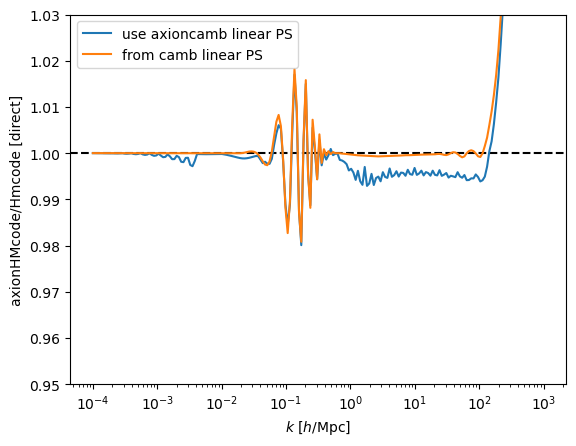

In [36]:
plt.axhline(y = 1, ls = '--', color='k')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_axioncamb_PS(np.log(kh_nonlin))) /pk_nonlin[0,:], label='use axioncamb linear PS')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_camb_PS(np.log(kh_nonlin))) /pk_nonlin[0,:], label='from camb linear PS')
plt.legend()
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel('axionHMcode/Hmcode [direct]')
plt.ylim(0.95, 1.03)


## python module hmcode

in pyhmcode the HMcode-2020 params can be switched on by tweaks = True, So we make a comparison with ans without the parameters.

In [ ]:
#Non-linear power spectrum directly from HMCode
# Wavenumbers [h/Mpc]
kh_nonlin = [1.22381e-04, 2.01773e-04, 3.32667e-04, 5.48475e-04, 9.04282e-04,
 1.49091e-03 ,2.45809e-03 ,4.05271e-03, 4.59233e-03, 5.20379e-03, 5.89666e-03,
 6.68179e-03, 7.57146e-03 ,8.57959e-03, 9.72195e-03, 1.10164e-02, 1.24832e-02,
 1.41454e-02, 1.60288e-02, 1.81630e-02, 2.05814e-02, 2.33218e-02, 2.64270e-02,
 2.99457e-02, 3.39330e-02, 3.84511e-02, 4.35708e-02, 4.93722e-02, 5.59460e-02,
 6.33951e-02, 7.08179e-02, 7.82407e-02, 8.56635e-02, 9.30863e-02, 1.00509e-01,
 1.07932e-01 ,1.15355e-01, 1.22778e-01, 1.30200e-01, 1.37623e-01, 1.45046e-01,
 1.52469e-01, 1.59892e-01, 1.67314e-01, 1.74737e-01, 1.82160e-01, 1.89583e-01,
 1.97006e-01, 2.04428e-01, 2.11851e-01, 2.19274e-01, 2.32559e-01, 2.46650e-01,
 2.61594e-01, 2.77443e-01, 2.94253e-01, 3.12081e-01, 3.30989e-01, 3.51043e-01,
 3.72313e-01, 3.94870e-01, 4.18795e-01, 4.44169e-01, 6.19887e-01, 8.65122e-01,
 1.20738e+00, 1.68503e+00, 2.35165e+00, 3.28199e+00, 4.58038e+00, 6.39244e+00,
 8.92136e+00 ,1.24508e+01, 1.73764e+01, 2.42508e+01, 3.38447e+01, 4.72341e+01,
 6.59205e+01, 9.19994e+01, 1.28396e+02, 1.79190e+02, 2.50080e+02, 3.49015e+02,
 4.87090e+02, 6.79789e+02, 9.48722e+02]
kh_nonlin=np.array(kh_nonlin)

# Redshifts
z_nonlin = [0.,]
z_nonlin = np.array(z_nonlin)

import hmcode

pk_nonlin_no_tweaks = hmcode.power(kh_nonlin, z_nonlin, results, T_AGN=None, verbose=True,tweaks=False, Mmin=1.e+7, Mmax=1.e+17, nM=100)
pk_nonlin_tweaks = hmcode.power(kh_nonlin, z_nonlin, results, T_AGN=None, verbose=True,tweaks=True, Mmin=1.e+7, Mmax=1.e+17, nM=100)



HMcode parameters
Halo mass range: 10^7.0 -> 10^17.0 Msun/h
Omega_m: 0.313
Neutrino mass fraction: 0.00%
Linear growth at z=0: 0.787

Redshift: 0.0
Scale factor: 1.0
Omega_m(z): 0.313
Un-normalisaed growth (= a for a << 1): 0.787
Normalised growth (= 1 at z = 0): 1.0
Accumulated growth (= a for a << 1): 0.933
Linear collapse threshold: 1.676
Virial halo overdensity: 301.5
Lagrangian radius range: 0.03016 -> 64.99 Mpc/h
RMS in matter field range: 7.069 -> 0.1186
Peak height range: 0.2371 -> 14.13
Non-linear Lagrangian radius: 2.505 Mpc/h
RMS in matter field at 8 Mpc/h: 0.8426
RMS in matter displacement field: 6.061 Mpc/h
Effective index at collapse scale: -1.988

HMcode predictions complete for 1 redshifts
Total HMcode run time: 2.562s

(1, 86)


In [ ]:
hmcode_params_LCDM_camb = HMcode_params.HMCode_param_dic(cosmos_LCDM, kh, pk[0,:])
PS_LCDM_matter_nonlin_axioncamb_PS_no_tweaks = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True,
                                                              full_2h = False)

PS_LCDM_matter_nonlin_camb_PS_no_tweaks = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, kh, pk[0,:], 
                                                              cosmos_LCDM, hmcode_params_LCDM_camb, cosmos_LCDM['Omega_m_0'],
                                                              alpha = False, 
                                                              eta_given = False, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True,
                                                              full_2h = False)


axioncamb_interp_tot_nonlin_axioncamb_PS_no_tweaks = interp1d(np.log(power_spec_dic_LCDM['k']), np.log(PS_LCDM_matter_nonlin_axioncamb_PS_no_tweaks[0]))
axioncamb_interp_tot_nonlin_camb_PS_no_tweaks = interp1d(np.log(kh), np.log(PS_LCDM_matter_nonlin_camb_PS_no_tweaks[0]))

PS_LCDM_matter_nonlin_axioncamb_PS_tweaks = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, power_spec_dic_LCDM['k'], power_spec_dic_LCDM['power_total'], 
                                                              cosmos_LCDM, hmcode_params_LCDM, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True,
                                                              full_2h = False)

PS_LCDM_matter_nonlin_camb_PS_tweaks = PS_nonlin_cold.func_non_lin_PS_matter(M_arr, kh, pk[0,:], 
                                                              cosmos_LCDM, hmcode_params_LCDM_camb, cosmos_LCDM['Omega_m_0'],
                                                              alpha = True, 
                                                              eta_given = True, 
                                                              one_halo_damping = True,
                                                              two_halo_damping = True,
                                                              full_2h = False)


axioncamb_interp_tot_nonlin_axioncamb_PS_tweaks = interp1d(np.log(power_spec_dic_LCDM['k']), np.log(PS_LCDM_matter_nonlin_axioncamb_PS_tweaks[0]))
axioncamb_interp_tot_nonlin_camb_PS_tweaks = interp1d(np.log(kh), np.log(PS_LCDM_matter_nonlin_camb_PS_tweaks[0]))


(0.95, 1.03)

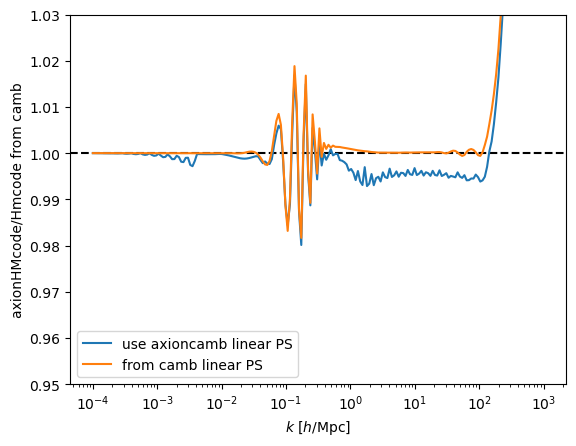

In [6]:
plt.axhline(y = 1, ls = '--', color='k')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_axioncamb_PS_tweaks(np.log(kh_nonlin))) /pk_nonlin_tweaks[0,:], label='use axioncamb linear PS, tweaks = True')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_camb_PS_tweaks(np.log(kh_nonlin))) /pk_nonlin_tweaks[0,:], label='from camb linear PS, tweaks = True')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_axioncamb_PS_no_tweaks(np.log(kh_nonlin))) /pk_nonlin_no_tweaks[0,:], label='use axioncamb linear PS, tweaks = False')
plt.semilogx(kh_nonlin,  np.exp(axioncamb_interp_tot_nonlin_camb_PS_no_tweaks(np.log(kh_nonlin))) /pk_nonlin_no_tweaks[0,:], label='from camb linear PS, tweaks = False')
plt.legend()
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel('axionHMcode/Hmcode [direct]')
plt.ylim(0.95, 1.03)
